p-Creode Expression Trends Along Trajectories
---
---

In [1]:
import pandas as pd
import numpy as np
from pygam import LinearGAM, GAM, s, l
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot; jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

### Read in all count and variance normalized raw data
Graph trajectory files are previously saved with fixed file name format

In [2]:
path_to_graphs = "traj_files/WT_traj_files/"

In [3]:
# pull all graph and trajectory files 
graph_traj_files = !ls $path_to_graphs | grep -v 'clust' | grep 'WT_graph[0-9]'
graph_traj_files = np.array( graph_traj_files)
# pull out all unique graph ids
graph_ids = np.unique([(file_itr).split('_')[0] + '_' + (file_itr).split('_')[1] + '_' for file_itr in graph_traj_files])
graph_ids

array(['WT_graph1_', 'WT_graph2_', 'WT_graph3_', 'WT_graph4_',
       'WT_graph5_', 'WT_graph6_', 'WT_graph7_', 'WT_graph8_',
       'WT_graph9_'], dtype='<U10')

### Plot curve fits for key expression markers to identify trajectory cell types 

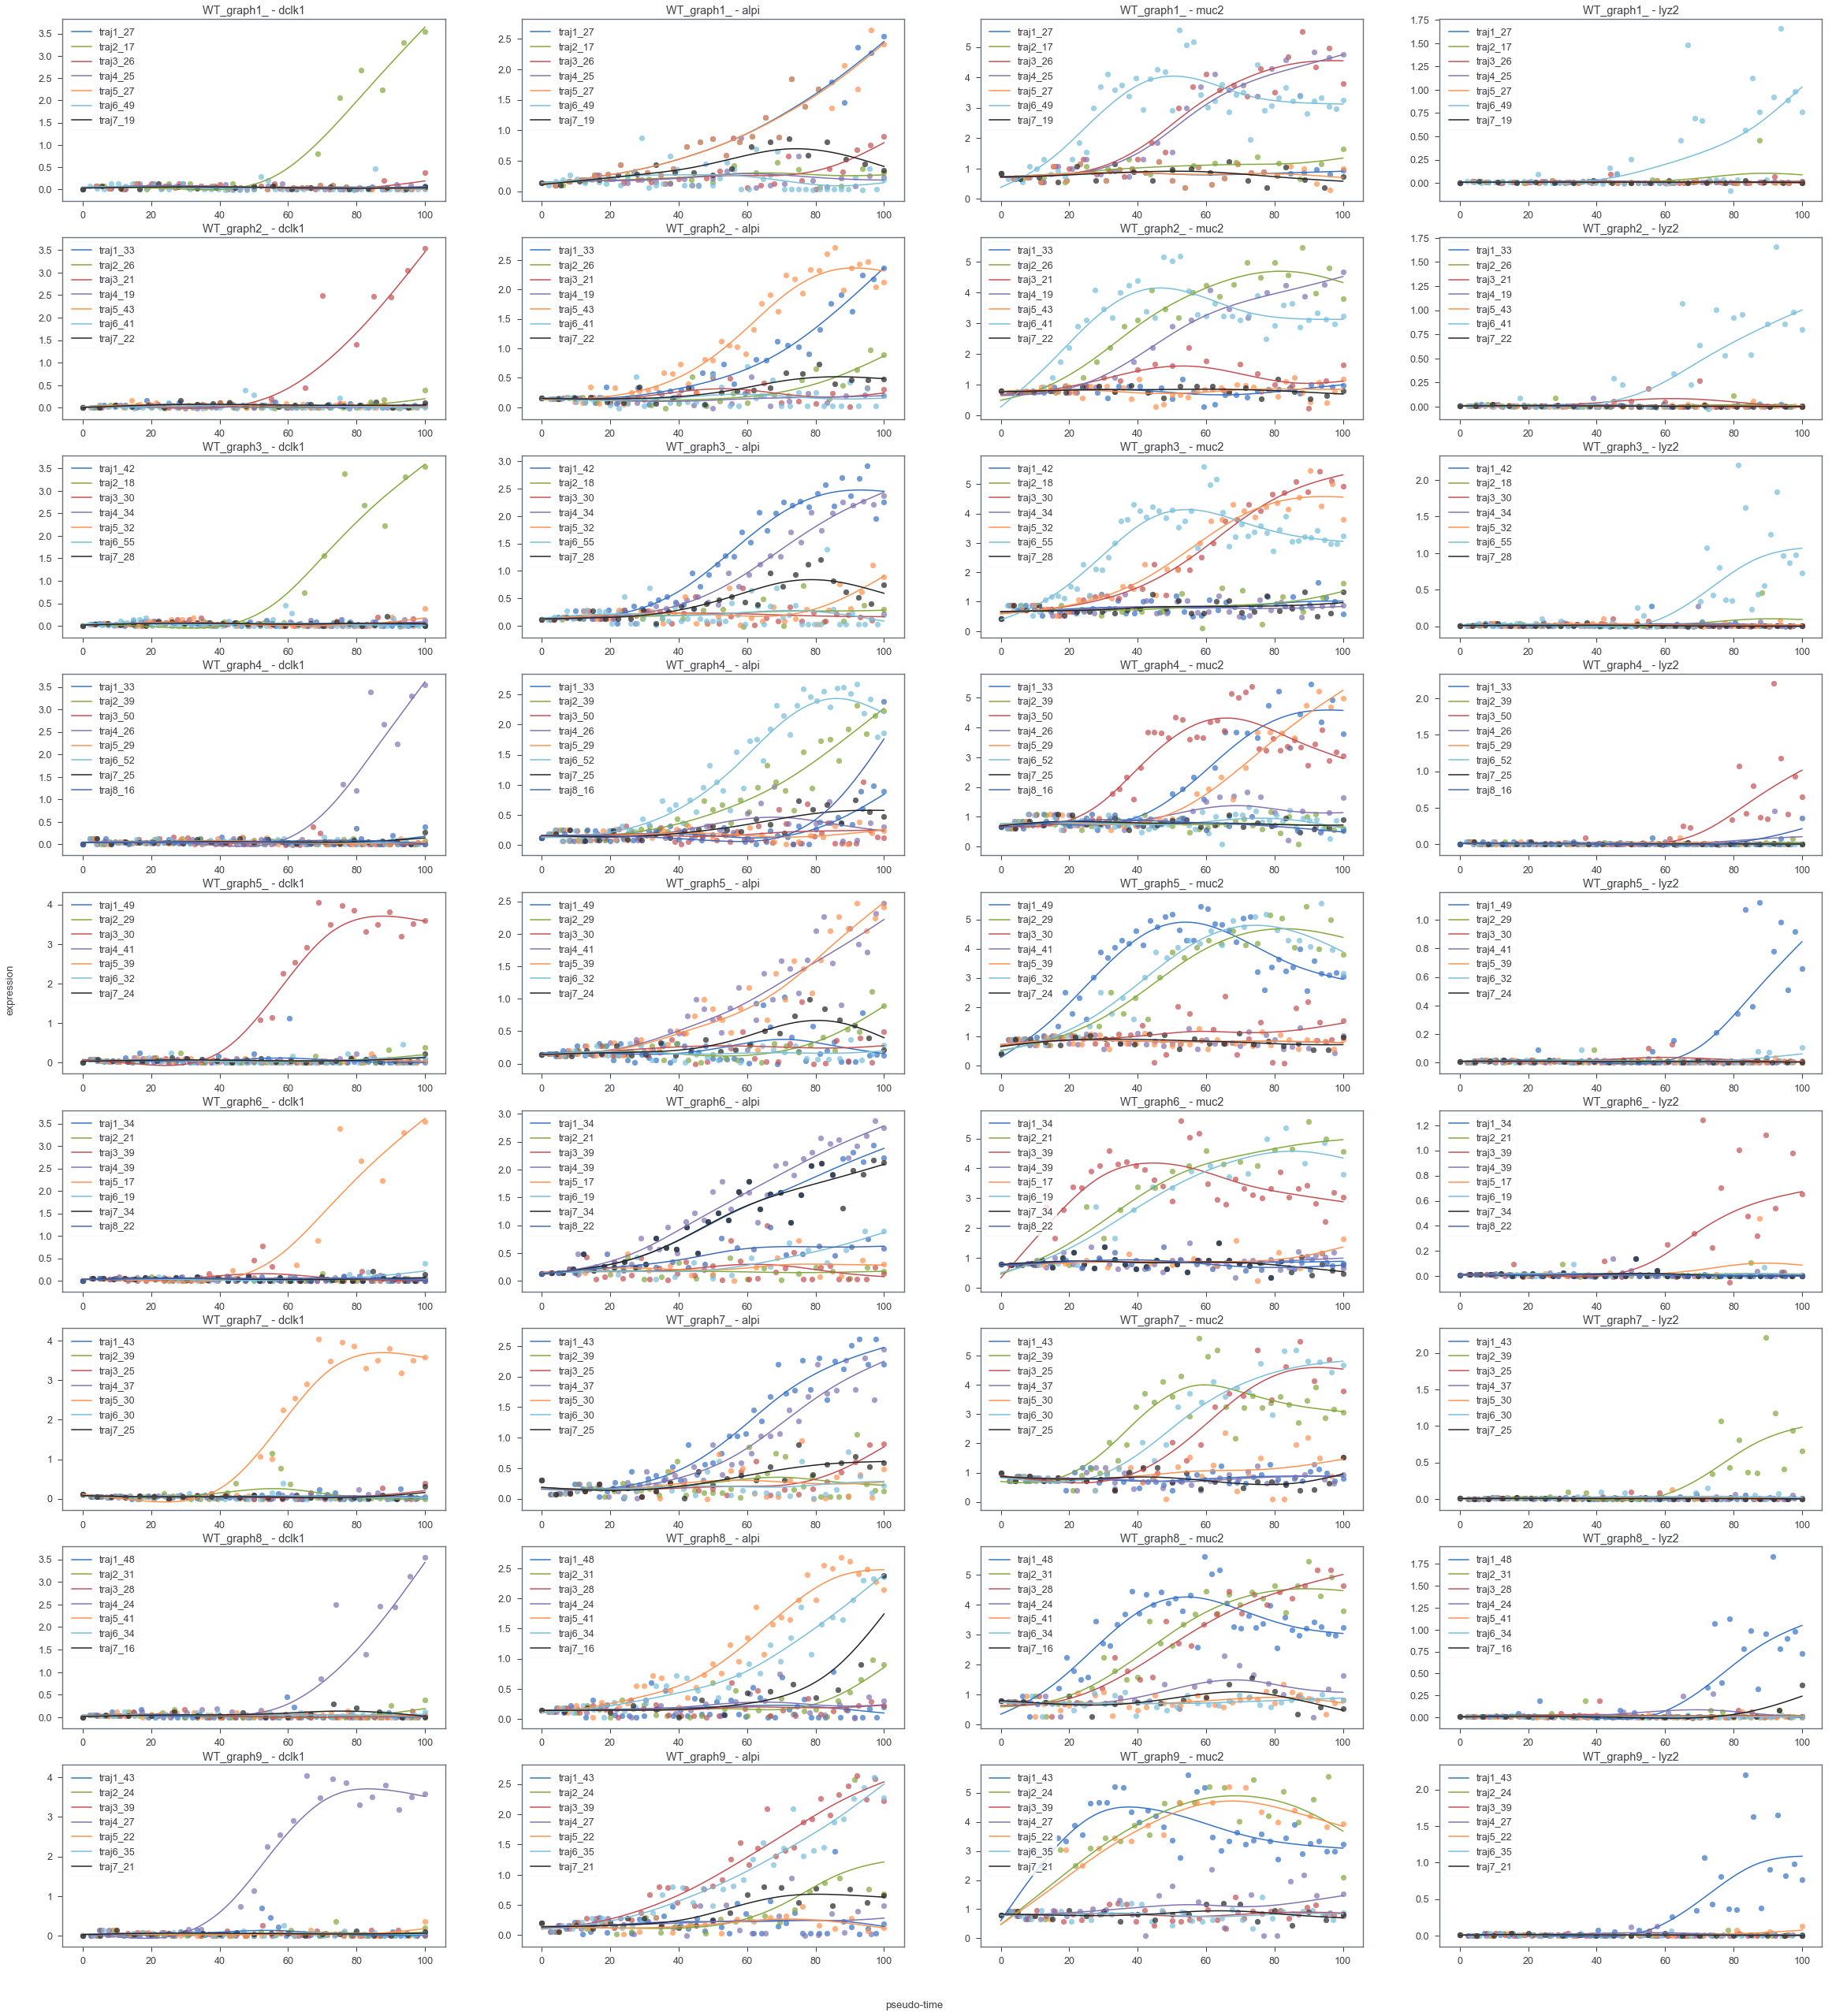

In [4]:
gene_ids   = ['dclk1','alpi','muc2','lyz2']  # define genes to plot
num_genes  = len( gene_ids)
num_graphs = len( graph_ids) 

fig = plt.figure( figsize=(num_genes*10,num_graphs*5))
plt_itr = 1
# Set common labels
fig.text( 0.5, 0.102, 'pseudo-time', ha='center', va='center')
fig.text( 0.102, 0.5, 'expression',  ha='center', va='center', rotation='vertical')

# loop through each graph id
for g_itr, g_id in enumerate( graph_ids, 1):

    # get matching trajectories for each graph id
    g_file_mask = [g_id in ii for ii in graph_traj_files]
    traj_files  = graph_traj_files[g_file_mask]
    # create list of ids for each traj
    traj_ids = [(itr).split('_')[2] for itr in traj_files]
    
    for gene_itr, gene_id in enumerate( gene_ids): 
        # create a figure and axis
        ax = fig.add_subplot(num_graphs,num_genes,plt_itr)
        plt_itr+=1

        for itr, t_file in enumerate( traj_files):
            # trajectory data points
            traj_df   = pd.read_csv( path_to_graphs + t_file, index_col=[0])
            traj_data = traj_df.loc[gene_id].values

            # git curve to gene of interest
            xx   = np.linspace( 0, 100, len(traj_data))
            ay   = traj_data
            gam = LinearGAM( s( 0, lam=0.6, n_splines=10), fit_intercept=False).fit( xx, ay)
            axx = gam.generate_X_grid( term=0)
            yyy = gam.predict( X=axx)

            # plot each trend
            ax.plot( axx, yyy, label=traj_ids[itr]+'_'+str(len(traj_data)))
            ax.scatter( xx, ay, alpha=0.7)
            
        ax.set_title( g_id+' - '+gene_id)
        ax.legend()


### Manually select trajectories for cell types of interest

In [5]:
####### graph IDs: 1  2  3  4  5  6  7  8  9
tuft_traj_ids   = [2, 3, 2, 4, 3, 5, 5, 4, 4]
entero_traj_ids = [1, 5, 1, 6, 4, 4, 1, 5, 3]
goblet_traj_ids = [3, 2, 5, 1, 6, 2, 6, 2, 2]
paneth_traj_ids = [6, 6, 6, 3, 1, 3, 2, 1, 1]

### Pull trajectory files for each graph

In [6]:
def grep_traj(graph_id, cell_id, path_to_graphs=path_to_graphs):
    traj_id = 'traj' + str(cell_id)
    traj_file = !ls $path_to_graphs | grep $graph_id | grep $traj_id
    return( traj_file[0])

In [7]:
tuft_files = []; entero_files = []; goblet_files = []; paneth_files = []

# pull trajectory files for each cell type 
for itr, g_id in enumerate(graph_ids):
    print(itr, g_id)
    tuft_files.append(grep_traj(g_id, tuft_traj_ids[itr], path_to_graphs))
    entero_files.append(grep_traj(g_id, entero_traj_ids[itr], path_to_graphs))
    goblet_files.append(grep_traj( g_id, goblet_traj_ids[itr], path_to_graphs))
    paneth_files.append(grep_traj( g_id, paneth_traj_ids[itr], path_to_graphs))

0 WT_graph1_
1 WT_graph2_
2 WT_graph3_
3 WT_graph4_
4 WT_graph5_
5 WT_graph6_
6 WT_graph7_
7 WT_graph8_
8 WT_graph9_


## Read in filtered gene list
Genes were selected by taking union of 2500 with highest variance over the tuft cell lineage from wildtype and ATOH runs

Other lineages with same selection criteria were added at reviewer request   

In [8]:
selected_genes = pd.read_csv("traj_files/linux_ordered_gene_names.csv", header=None)
selected_genes.shape

(3420, 1)

## Load data for each trajectory

In [9]:
output_path = "fits/WT_fits/"

In [10]:
def norm( y):
    y_norm = (y - min(y)) / (max(y)-min(y))
    return( y_norm)

In [11]:
def norm_curve_fit( file_list, cell_type, n_splines=10):

    for file_itr, data_file in enumerate( file_list):
        print( cell_type, graph_ids[file_itr], data_file)
        
        data = pd.read_csv("{}{}".format(path_to_graphs, data_file), index_col=[0])
        filt_data = data.loc[selected_genes[0],]
        num_genes, num_nodes = filt_data.shape

        print(data.shape, filt_data.shape)
        
        x = np.arange(num_nodes)
        # empty array to vstack curve fits 
        fits = np.empty((0,100), dtype=float)
        # fit curves to trajectories using GAM
        names = []
        for itr in range(num_genes):
            y = filt_data.iloc[itr,:]
            if(~np.any(np.isnan(y))):
                names.append(y.name)
                gam  = LinearGAM(s(0, n_splines=n_splines), fit_intercept=False).fit(x, y)
                xx   = gam.generate_X_grid(term=0)
                # with on variable gam.partial_dependence=gam.predict 
                pre  = gam.partial_dependence(term=0, X=xx)
                npre = norm(pre)
                if(np.any(np.isnan(npre))):
                    print("{} is zero across trajectory".format(filt_data.index[itr]))
                    npre[:] = 0.0000000001
                fits = np.vstack((fits, npre))
                
        fits_df = pd.DataFrame(fits, index=names)
        fits_df.to_csv("{}{}{}_norm_trends.csv".format(output_path, graph_ids[file_itr], cell_type))
        del fits, fits_df
    return

In [12]:
norm_curve_fit(tuft_files,   "tuft",   n_splines=10)
norm_curve_fit(entero_files, "entero", n_splines=10)
norm_curve_fit(goblet_files, "goblet", n_splines=10)
norm_curve_fit(paneth_files, "paneth", n_splines=10)

tuft WT_graph1_ WT_graph1_traj2_analytes.csv
(38487, 17) (3433, 17)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


tuft WT_graph2_ WT_graph2_traj3_analytes.csv
(38487, 21) (3433, 21)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


tuft WT_graph3_ WT_graph3_traj2_analytes.csv
(38487, 18) (3433, 18)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


tuft WT_graph4_ WT_graph4_traj4_analytes.csv
(38487, 26) (3433, 26)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


tuft WT_graph5_ WT_graph5_traj3_analytes.csv
(38487, 30) (3433, 30)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


tuft WT_graph6_ WT_graph6_traj5_analytes.csv
(38487, 17) (3433, 17)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


tuft WT_graph7_ WT_graph7_traj5_analytes.csv
(38487, 30) (3433, 30)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


tuft WT_graph8_ WT_graph8_traj4_analytes.csv
(38487, 24) (3433, 24)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


tuft WT_graph9_ WT_graph9_traj4_analytes.csv
(38487, 27) (3433, 27)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


entero WT_graph1_ WT_graph1_traj1_analytes.csv
(38487, 27) (3433, 27)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


entero WT_graph2_ WT_graph2_traj5_analytes.csv
(38487, 43) (3433, 43)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


entero WT_graph3_ WT_graph3_traj1_analytes.csv
(38487, 42) (3433, 42)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


entero WT_graph4_ WT_graph4_traj6_analytes.csv


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(38487, 52) (3433, 52)
entero WT_graph5_ WT_graph5_traj4_analytes.csv
(38487, 41) (3433, 41)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


entero WT_graph6_ WT_graph6_traj4_analytes.csv
(38487, 39) (3433, 39)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


entero WT_graph7_ WT_graph7_traj1_analytes.csv
(38487, 43) (3433, 43)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


entero WT_graph8_ WT_graph8_traj5_analytes.csv
(38487, 41) (3433, 41)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


entero WT_graph9_ WT_graph9_traj3_analytes.csv
(38487, 39) (3433, 39)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


goblet WT_graph1_ WT_graph1_traj3_analytes.csv
(38487, 26) (3433, 26)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


goblet WT_graph2_ WT_graph2_traj2_analytes.csv
(38487, 26) (3433, 26)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


goblet WT_graph3_ WT_graph3_traj5_analytes.csv
(38487, 32) (3433, 32)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


goblet WT_graph4_ WT_graph4_traj1_analytes.csv
(38487, 33) (3433, 33)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


goblet WT_graph5_ WT_graph5_traj6_analytes.csv
(38487, 32) (3433, 32)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


goblet WT_graph6_ WT_graph6_traj2_analytes.csv
(38487, 21) (3433, 21)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


goblet WT_graph7_ WT_graph7_traj6_analytes.csv
(38487, 30) (3433, 30)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


goblet WT_graph8_ WT_graph8_traj2_analytes.csv
(38487, 31) (3433, 31)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


goblet WT_graph9_ WT_graph9_traj2_analytes.csv
(38487, 24) (3433, 24)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


paneth WT_graph1_ WT_graph1_traj6_analytes.csv
(38487, 49) (3433, 49)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


paneth WT_graph2_ WT_graph2_traj6_analytes.csv
(38487, 41) (3433, 41)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


paneth WT_graph3_ WT_graph3_traj6_analytes.csv


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(38487, 55) (3433, 55)
paneth WT_graph4_ WT_graph4_traj3_analytes.csv
(38487, 50) (3433, 50)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


paneth WT_graph5_ WT_graph5_traj1_analytes.csv
(38487, 49) (3433, 49)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


paneth WT_graph6_ WT_graph6_traj3_analytes.csv
(38487, 39) (3433, 39)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


paneth WT_graph7_ WT_graph7_traj2_analytes.csv
(38487, 39) (3433, 39)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


paneth WT_graph8_ WT_graph8_traj1_analytes.csv


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(38487, 48) (3433, 48)
paneth WT_graph9_ WT_graph9_traj1_analytes.csv
(38487, 43) (3433, 43)


/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
